# Today's Aim
In the Mapper visualisation, make small images of the molecules show up instead of their index in the dataset.
This allows everything to look much neater and practical chemists can see what's going on intuitively.

I also intend to try out some different clustering algorithms.
## Other Aims:
1. ~~Use PCA on the fingerprints to identify a few important sections, and use that as the lens.~~
    1. We could use nonlinear Multidimensional Scaling on the Tanimoto similarity, which avoids the pitfalls of PCA.
2. Use a different colouring function (presence of functional group, max(activity), min(activity), stdev(activity))
3. For each drug, generate a bitvector of "which target has this been tested on". Then cluster in "drug-target" space using that bitvectorand see what we spot.
4. For a specific and well-tested target, generate a classifier (e.g. random forest) to predict how effective a drug is against it. Then, use the Fibres of Failure method (see [L. Carlsson, G. Carlsson and M. Vejdemo-Johansson, Pre-print.](https://arxiv.org/abs/1803.00384)) to predict when it goes wrong.

## Dead Ends:
1. Highlighting molecules by what they share with the links.
2. Using PCA on the fingerprints - this over-weights the absence of features (it is $ \propto \text{XNOR}(A, B) $), such that small molecules show up very similar (see [E. Martin and E. Cao, J. Comput. Aided. Mol. Des., 2015, 29, 387–395.](http://doi.org/10.1007/s10822-014-9819-y))

## Pitfalls:
1. Watch out for the lens just discretising the dataset. This will often show up as a ladder in 1D, but make sure to plot it in 2D
2. Compute2DCoords will often mangle the data when outputting. Workaround is to just plot them from the .sd file and load them in as you see fit.


In [17]:
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import rdkit.Chem.Fingerprints.ClusterMols
from IPython.display import SVG, IFrame
import gzip
import os
import pickle
import pandas as pd
import kmapper as km
from kmapper import jupyter
from sklearn import cluster
import scipy
import hdbscan # Provides a better clustering algorithm.

In [9]:
with open("../data/processed/curated_set_with_publication_year.pd.pkl", "rb") as infile:
    df = pickle.load(infile)

In [10]:
from collections import Counter
possible_targets = Counter([item for item in df["TGT_CHEMBL_ID"]])
print(len(possible_targets))
print(len(df))
print(possible_targets)
first_target = df["TGT_CHEMBL_ID"] == "CHEMBL240"
sub_df = df[first_target]

1227
314767
Counter({'CHEMBL240': 4703, 'CHEMBL253': 3472, 'CHEMBL218': 2997, 'CHEMBL251': 2976, 'CHEMBL228': 2853, 'CHEMBL264': 2548, 'CHEMBL226': 2544, 'CHEMBL217': 2473, 'CHEMBL344': 2358, 'CHEMBL243': 2315, 'CHEMBL256': 2304, 'CHEMBL205': 2257, 'CHEMBL279': 2142, 'CHEMBL261': 2089, 'CHEMBL4235': 2020, 'CHEMBL244': 2010, 'CHEMBL222': 2003, 'CHEMBL233': 1998, 'CHEMBL4078': 1994, 'CHEMBL284': 1950, 'CHEMBL237': 1908, 'CHEMBL259': 1828, 'CHEMBL4822': 1799, 'CHEMBL3371': 1773, 'CHEMBL214': 1703, 'CHEMBL313': 1690, 'CHEMBL3594': 1678, 'CHEMBL203': 1659, 'CHEMBL224': 1643, 'CHEMBL4296': 1594, 'CHEMBL260': 1589, 'CHEMBL235': 1575, 'CHEMBL234': 1569, 'CHEMBL225': 1565, 'CHEMBL236': 1550, 'CHEMBL220': 1542, 'CHEMBL238': 1518, 'CHEMBL247': 1474, 'CHEMBL255': 1445, 'CHEMBL3952': 1424, 'CHEMBL2039': 1403, 'CHEMBL340': 1386, 'CHEMBL3242': 1380, 'CHEMBL204': 1347, 'CHEMBL5071': 1332, 'CHEMBL239': 1324, 'CHEMBL325': 1298, 'CHEMBL5763': 1282, 'CHEMBL2034': 1258, 'CHEMBL4015': 1234, 'CHEMBL2409': 12

In [11]:
fingerprint_data = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),3) for smiles in sub_df["SMILES"]]
try:
    sub_df.insert(0, "FINGERPRINT",fingerprint_data)
except ValueError:
    # If we re-run this cell, we can't reinsert the data (so instead we just replace it)
    sub_df.loc["FINGERPRINT"] = fingerprint_data

In [23]:
sub_df

,FINGERPRINT,BIOACT_PCHEMBL_VALUE,CMP_ACD_LOGD,CMP_ACD_LOGP,CMP_ALOGP,CMP_AROMATIC_RINGS,CMP_CHEMBL_ID,CMP_FULL_MWT,CMP_HBA,CMP_HBD,...,CMP_STANDARD_INCHI_KEY,CMP_STRUCTURE_TYPE,CMP_TYPE_PROTEIN,CMP_TYPE_SMALL_MOLECULE,DOC_YEAR,SMILES,TC_key,TGT_CHEMBL_ID,TGT_ORGANISM,TGT_TID
CHEMBL240 - CHEMBL167779,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",6.740,3.70,5.85,6.48,3,CHEMBL167779,405.96,2,0,...,GKIRPKYJQBWNGO-QPLCGJKRSA-N,MOL,False,True,2011,CCN(CC)CCOc1ccc(/C(=C(\Cl)c2ccccc2)c2ccccc2)cc1,CHEMBL240 - CHEMBL167779,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL351231,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.100,2.80,5.37,4.77,3,CHEMBL351231,330.42,2,0,...,KFHYZKCRXNRKRC-MRXNPFEDSA-N,MOL,False,True,2010,C[C@@H]1CCCN1CCc1cc2cc(-c3ccc(C#N)cc3)ccc2o1,CHEMBL240 - CHEMBL351231,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL61536,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.260,0.26,1.31,3.70,3,CHEMBL61536,512.69,4,0,...,YFEPUDFZMYDTMF-UHFFFAOYSA-N,MOL,False,True,2008,Cc1cc[n+]([O-])c(C)c1C(=O)N1CCC(C)(N2CCC(N(Cc3...,CHEMBL240 - CHEMBL61536,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL175832,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.250,4.53,4.55,4.68,2,CHEMBL175832,401.42,3,0,...,VDURQHWFSXZAER-UHFFFAOYSA-N,MOL,False,True,2005,O=S(=O)(c1ccc(F)cc1)C1(F)CCN(CCc2ccc(F)cc2F)CC1,CHEMBL240 - CHEMBL175832,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1671889,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.220,1.51,1.67,1.33,3,CHEMBL1671889,479.33,6,1,...,UMNUGEIXQBLVCO-UHFFFAOYSA-N,MOL,False,True,2011,N#Cc1ccc(Cn2cncc2CNC2CCN(C(=O)c3cncc(Br)c3)C2=...,CHEMBL240 - CHEMBL1671889,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1671908,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",4.130,1.46,3.40,4.07,1,CHEMBL1671908,489.63,5,3,...,YTQSVAKKJXBNDL-UHFFFAOYSA-N,MOL,False,True,2011,CCC1=C(C)CC(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CC...,CHEMBL240 - CHEMBL1671908,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1649912,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.370,2.96,5.30,4.01,2,CHEMBL1649912,513.67,4,1,...,PTUIAFZYMVYAII-QUMGSSFMSA-N,MOL,False,True,2011,Cc1nc(C(C)C)n([C@@H]2C[C@@H]3CC[C@H](C2)N3CC[C...,CHEMBL240 - CHEMBL1649912,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1683351,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.130,-1.63,1.98,-1.63,1,CHEMBL1683351,388.42,6,1,...,CACJJIUIFBOUQZ-UHFFFAOYSA-N,MOL,False,True,2010,N#Cc1ccc(N2CCN(Cc3cc(C(=O)O)c(=O)n4ccccc34)CC2...,CHEMBL240 - CHEMBL1683351,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1672351,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.230,3.17,3.92,4.52,3,CHEMBL1672351,367.46,3,2,...,WFOBNYAVMIYRCG-UHFFFAOYSA-N,MOL,False,True,2011,CC(C)(C)Cc1c[nH]c(C(C)(O)Cc2ccc(-c3ccc(F)cn3)c...,CHEMBL240 - CHEMBL1672351,CHEMBL240,Homo sapiens,165
CHEMBL240 - CHEMBL1672352,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.380,2.97,3.63,4.24,3,CHEMBL1672352,367.46,3,2,...,SQDJZWNPXIGNRP-UHFFFAOYSA-N,MOL,False,True,2011,CC(C)(C)Cc1c[nH]c(CC(C)(O)c2ccc(-c3ccc(F)cn3)c...,CHEMBL240 - CHEMBL1672352,CHEMBL240,Homo sapiens,165


In [12]:
fingerprint_data = []
for index, series in sub_df.iterrows():
    fingerprint_data.append(series["FINGERPRINT"])

In [19]:
sq_distance_matrix = np.zeros([len(fingerprint_data), len(fingerprint_data)])
for row in range(len(fingerprint_data)):
    fingerprint = fingerprint_data[row]
    for col in range(row):
        other = fingerprint_data[col]
        dissimiliarity = 1.0 - rdkit.DataStructs.TanimotoSimilarity(fingerprint, other)
        sq_distance_matrix[row, col] = dissimiliarity
        sq_distance_matrix[col, row] = dissimiliarity
# Bafflingly. doing it the SciPy way is about twice as slow (57s vs 28s)
# scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(fingerprint_data, metric="jaccard"))

27.8 s ± 776 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
numerical_cols = [sub_df.columns[pos] for pos, item in enumerate(sub_df.dtypes) if item in [np.float64, np.int64]]
new_data = sub_df[numerical_cols].to_numpy()
dimensional_data = np.array([row[0] for row in new_data])
print(dimensional_data)
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(dimensional_data, X=sq_distance_matrix, precomputed=True, cover=km.Cover(n_cubes=15, perc_overlap=0.20), clusterer=hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2))

[6.74 6.1  6.26 ... 5.28 6.87 5.16]
KeplerMapper(verbose=1)
Mapping on data shaped (4703, 4703) using lens shaped (4703,)

Creating 15 hypercubes.

Created 263 edges and 411 nodes in 0:00:00.593690.


In [55]:
for index, series in sub_df.iterrows():
    molec = Chem.MolFromSmiles(series["SMILES"])
    chembl_id = series["CMP_CHEMBL_ID"]
    rdDepictor.Compute2DCoords(molec)
    drawer = rdMolDraw2D.MolDraw2DSVG(250, 250)
    drawer.DrawMolecule(molec)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    with open(f"./Figures/{chembl_id}.svg", "w") as svgfile:
        svgfile.write(svg)

In [25]:
# Visualize it
custom_tooltips=np.array([f"<img src='./Figures/{chembl_id}.svg'>" for chembl_id in sub_df["CMP_CHEMBL_ID"]])
print(custom_tooltips)
mapper.visualize(graph, path_html="2019-04-03-mb-improved-visuals-map.html",
                 title="Map Dataframe Test", color_function=dimensional_data, custom_tooltips=custom_tooltips)
IFrame("2019-04-03-mb-improved-visuals-map.html", 800, 600)

["<img src='./Figures/CHEMBL167779.svg'>"
 "<img src='./Figures/CHEMBL351231.svg'>"
 "<img src='./Figures/CHEMBL61536.svg'>" ...
 "<img src='./Figures/CHEMBL3287929.svg'>"
 "<img src='./Figures/CHEMBL3299132.svg'>"
 "<img src='./Figures/CHEMBL3287218.svg'>"]
Wrote visualization to: 2019-04-03-mb-improved-visuals-map.html


How do we actually extract meaningful data from this list? Time to visualise it!

In [27]:
def draw_molecule(molec, molsize, highlight_atoms=None):
    rdDepictor.Compute2DCoords(molec)
    drawer = rdMolDraw2D.MolDraw2DSVG(molsize[0], molsize[1], highlight_atoms=highlight_atoms)
    drawer.DrawMolecule(molec)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace("svg:", "")))

## Different lenses
Here I am going to try to do a multidimensional scaling analysis of the distance data to utal the most important dimesions. This requires a bit of thinking on what the MDS actually outputs, and how it relates to the physical features of chemical space.

We must use a nonlinear MDS because $ 1 - T_C $ is not necessarily positive semidefinite.

In [22]:
from sklearn.manifold import MDS
print(sq_distance_matrix.shape)
transformed_data = MDS(n_components=2, dissimilarity="precomputed", metric=False).fit_transform(sq_distance_matrix)
transformed_data

(4703, 4703)


array([[-0.24866669, -0.03939913],
       [-0.19340256,  0.35383274],
       [ 0.27805531,  0.37229919],
       ...,
       [-0.17715746,  0.64117802],
       [ 0.08399538,  0.31937563],
       [-0.19058749,  0.30983455]])

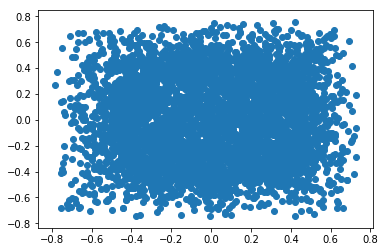

In [25]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])

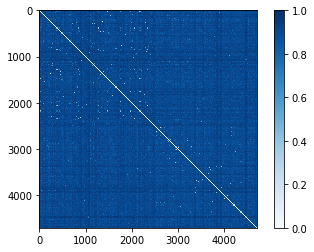

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(sq_distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [38]:
mapper = km.KeplerMapper(verbose=1)

graph = mapper.map(transformed_data,
                   X=sq_distance_matrix,
                   precomputed=True,
                   cover=km.Cover(n_cubes=10, perc_overlap=0.25),
                   clusterer=hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10, min_samples=3))
mapper.visualize(graph, path_html="2019-04-03-mb-improved-visuals-map-mds.html",
                 title="Lensed by MDS", color_function=dimensional_data, custom_tooltips=custom_tooltips)
IFrame("2019-04-03-mb-improved-visuals-map-mds.html", 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (4703, 4703) using lens shaped (4703, 2)

Creating 100 hypercubes.

Created 211 edges and 91 nodes in 0:00:00.394443.
Wrote visualization to: 2019-04-03-mb-improved-visuals-map-mds.html
